### Análise Comparativa de Modelos – Churn Prediction


- DataStorm


Maria Naiara Lima Flor

Clara Alyne de Aguiar

Neiviene Costa

Alana Sales

 1. Metodologia

 ## Metodologia

Neste projeto, seguimos a metodologia de Ciência de Dados baseada no ciclo CRISP-DM. Após a análise exploratória e o entendimento dos dados, avançamos para o desenvolvimento de modelos preditivos.

O objetivo é prever a evasão de clientes (churn) com base em atributos demográficos e comportamentais. Adotamos a seguinte abordagem:

- Pré-processamento completo dos dados (tratamento de nulos, codificação, normalização);
- Seleção e treinamento de múltiplos modelos;
- Avaliação com validação cruzada e GridSearch para selecionar hiperparâmetros;
- Avaliação Holdout com os melhores modelos;
- Comparação com métricas apropriadas e análise crítica dos resultados.




 2. Configuração do Experimento

  2.1 Importação de bibliotecas e dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.pipeline import Pipeline


# Carregando os dados
url = 'https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/churn.csv'
df = pd.read_csv(url)


 2.2 Pré-processamento dos dados

 Tratamento de valores nulos



In [ ]:
# Verificando valores nulos
print(df.isnull().sum())


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Como não há valores nulos não será necessário realizar o tratamento.

Removendo colunas inúteis

In [ ]:
# Lista de colunas que queremos remover
colunas_inuteis = ['RowNumber', 'CustomerId', 'Surname']

# Remove somente as que existem
df.drop(columns=colunas_inuteis, inplace=True)


 Codificação de variáveis qualitativas

In [ ]:
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first=True)

 Separação entre variáveis preditoras e alvo

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited']


 2.3 Validação dos Modelos

 Validação escolhida: GridSearchCV com 10 folds (K-fold) e avaliação Holdout

A técnica escolhida para o ajuste de hiperparâmetros foi a validação cruzada k-fold com k=10, aplicada por meio do GridSearchCV. Essa abordagem permite uma avaliação robusta e balanceada do desempenho dos modelos durante o treinamento, garantindo o uso eficiente de todos os dados e reduzindo a variância na avaliação.

Após a seleção dos melhores hiperparâmetros com base no F1-Score médio da validação cruzada, os modelos foram reajustados com os dados de treino e avaliados separadamente em um conjunto de teste (avaliação holdout). Essa etapa final foi utilizada para estimar o desempenho real dos modelos em dados não vistos, oferecendo uma perspectiva mais confiável da sua generalização.




 3. Modelagem e Comparação

   3.1 Modelos utilizados





Selecionamos os seguintes modelos para a tarefa de classificação:

1. **Baseline:** DummyClassifier (estratégia "most_frequent")
2. **Modelo 1:** Regressão Logística
3. **Modelo 2:** Árvore de Decisão (DecisionTreeClassifier)
4. **Modelo 3:** k-Nearest Neighbors (KNN)
5. **Modelo 4:** Suporte a Vetores de Máquinas (SVM)

Todos os modelos foram avaliados com as métricas: **Accuracy** e **F1-Score**.


 3.2 Avaliação com k-fold (GridSearch)

In [ ]:
# Separação treino-teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state=3)


In [ ]:
# Dicionário com modelos e hiperparâmetros (com Pipeline)
models_params = {
    'Logistic Regression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['liblinear', 'lbfgs']
        }
    },
    'Decision Tree': {
        'model': Pipeline([
            ('scaler', StandardScaler()),  # Não necessário, mas incluído para consistência
            ('clf', DecisionTreeClassifier())
        ]),
        'params': {
            'clf__max_depth': [3, 5, 10, None],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'KNN': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC())
        ]),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    }
}


# Métricas a serem avaliadas
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy'
}

# Treinamento com GridSearchCV para ambas métricas
results = {}

for name, mp in models_params.items():
    print(f"Treinando: {name}")
    grid = GridSearchCV(
        mp['model'],
        mp['params'],
        cv=10,
        scoring=scoring,
        refit='f1',  # Usa F1 para selecionar os melhores parâmetros
        n_jobs=-1
    )
    grid.fit(X_treino, y_treino)
    results[name] = {
        'F1-Score Médio (CV)': round(grid.cv_results_['mean_test_f1'][grid.best_index_], 4),
        'Acurácia Média (CV)': round(grid.cv_results_['mean_test_accuracy'][grid.best_index_], 4),
        'Melhores Parâmetros': grid.best_params_
    }

# Exibe os resultados
for modelo, res in results.items():
    print(f"\n {modelo}")
    print("F1-Score Médio (CV):", res['F1-Score Médio (CV)'])
    print("Acurácia Média (CV):", res['Acurácia Média (CV)'])
    print("Melhores Parâmetros:", res['Melhores Parâmetros'])


Treinando: Logistic Regression
Treinando: Decision Tree
Treinando: KNN
Treinando: SVM

 Logistic Regression
F1-Score Médio (CV): 0.3213
Acurácia Média (CV): 0.81
Melhores Parâmetros: {'clf__C': 1, 'clf__solver': 'liblinear'}

 Decision Tree
F1-Score Médio (CV): 0.5571
Acurácia Média (CV): 0.855
Melhores Parâmetros: {'clf__max_depth': 5, 'clf__min_samples_split': 2}

 KNN
F1-Score Médio (CV): 0.4779
Acurácia Média (CV): 0.8191
Melhores Parâmetros: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}

 SVM
F1-Score Médio (CV): 0.5678
Acurácia Média (CV): 0.8559
Melhores Parâmetros: {'clf__C': 10, 'clf__kernel': 'rbf'}


3.3 Holdout com os modelos campeões

In [ ]:
# Dicionário com os melhores modelos e hiperparâmetros
best_models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=1, solver='liblinear', max_iter=1000))
    ]),
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()),  # Mantido por consistência
        ('clf', DecisionTreeClassifier(max_depth=5, min_samples_split=2))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=3, weights='uniform'))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(C=10, kernel='rbf'))
    ])
}

test_results = {
    'Modelo': [],
    'F1-Score (teste)': [],
    'Acurácia (teste)': []
}

# Avaliação dos modelos
for name, model in best_models.items():
    model.fit(X_treino, y_treino)
    y_pred = model.predict(X_teste)

    f1 = f1_score(y_teste, y_pred)
    acc = accuracy_score(y_teste, y_pred)

    test_results['Modelo'].append(name)
    test_results['F1-Score (teste)'].append(round(f1, 4))
    test_results['Acurácia (teste)'].append(round(acc, 4))


In [ ]:
# Converter para DataFrame
df_resultados_teste = pd.DataFrame(test_results)
df_resultados_teste_ordenado = df_resultados_teste.sort_values(by='F1-Score (teste)', ascending=False)

# Exibir
print(df_resultados_teste_ordenado)

                Modelo  F1-Score (teste)  Acurácia (teste)
3                  SVM            0.5651            0.8615
1        Decision Tree            0.5100            0.8530
2                  KNN            0.4934            0.8285
0  Logistic Regression            0.3309            0.8140


4. Resultados e Discussão

### Tabela Comparativa

|Modelo|Acurácia Média|F1-Score Médio|
|---|---|---|
|SVM|0\.8615|0\.5651|
|Decision Tree|0\.8525|0\.5092|
|KNN|0\.8285|0\.4934|
|Logistic Regression|0\.8140|0\.3309|
|Dummy|0\.7963|0\.0|

### Discussão

- O modelo **Dummy**, que apenas repete a classe majoritária, serve como *baseline* e apresentou desempenho limitado, com F1-Score igual a zero.
- O **SVM**  foi o modelo com melhor desempenho geral, alcançando a maior acurácia (0.8615) e o maior F1-Score (0.5651), demonstrando bom equilíbrio entre precisão e recall.
- A **Árvore de Decisão** teve desempenho próximo ao SVM, com F1-Score competitivo (0.5092) e boa acurácia (0.8525), sendo uma alternativa eficaz e interpretável.
- O **KNN** apresentou desempenho intermediário, com acurácia razoável (0.8285), mas F1-Score inferior (0.4934), sugerindo que sua performance foi prejudicada pela sensibilidade à distribuição dos dados.
- A **Regressão Logística** teve a menor performance entre os modelos não-baseline, com acurácia de 0.8140 e um F1-Score significativamente inferior (0.3309), o que pode indicar dificuldades em capturar padrões em dados desbalanceados.


Visualização dos Resultados



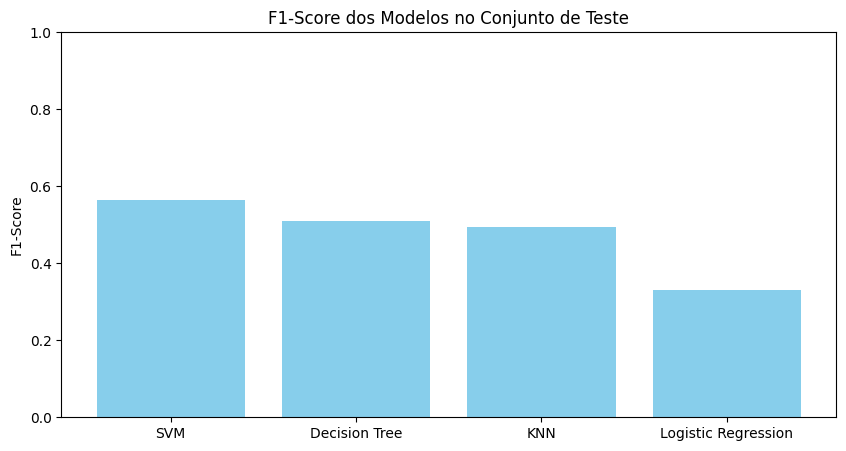

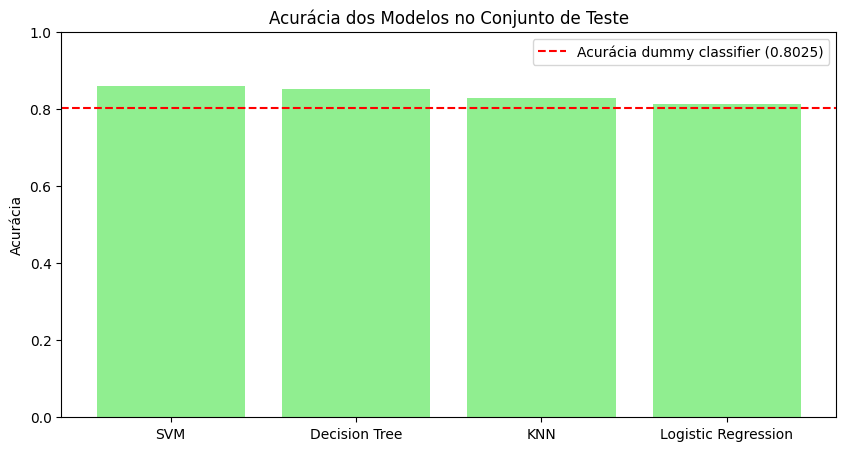

In [ ]:
# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.bar(df_resultados_teste_ordenado['Modelo'], df_resultados_teste_ordenado['F1-Score (teste)'], color='skyblue')
plt.title('F1-Score dos Modelos no Conjunto de Teste')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

# Treinar e avaliar o baseline
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_treino, y_treino)
y_baseline = baseline.predict(X_teste)
acc_baseline = accuracy_score(y_teste, y_baseline)

# Plot Acurácia com linha do baseline
plt.figure(figsize=(10, 5))
plt.bar(df_resultados_teste_ordenado['Modelo'], df_resultados_teste_ordenado['Acurácia (teste)'], color='lightgreen')
plt.axhline(y=acc_baseline, color='red', linestyle='--', label=f'Acurácia dummy classifier ({round(acc_baseline, 4)})')
plt.title('Acurácia dos Modelos no Conjunto de Teste')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.legend()
plt.show()


 5. Limitações e Próximos Passos



###  Limitações

- A base de dados é balanceada, mas o F1-Score revela que há margem para melhorias no recall da classe minoritária.

###  Próximos Passos

- Aplicar técnicas de *feature selection*;
- Usar modelos ensemble (Random Forest, XGBoost);
- Avaliar o impacto de técnicas de oversampling (SMOTE).


Este projeto aplicou a metodologia CRISP-DM para prever a evasão de clientes (churn) com base em dados demográficos e comportamentais. Durante o desenvolvimento, foram realizados processos completos de pré-processamento, modelagem, validação e otimização dos modelos, incluindo a aplicação de GridSearch para busca dos melhores hiperparâmetros.

Os resultados indicam que o modelo SVM apresentou o melhor desempenho, alcançando a maior acurácia média (0,8615) e o maior F1-Score médio (0,5651), demonstrando um bom equilíbrio entre precisão e recall. A Árvore de Decisão também se mostrou uma alternativa eficaz, com desempenho competitivo (F1-Score médio de 0,5092) e boa acurácia (0,8525), além de maior interpretabilidade.

Modelos como KNN e Regressão Logística tiveram desempenho inferior, com F1-Scores médios de 0,4934 e 0,3309, respectivamente, possivelmente refletindo dificuldades em lidar com a desproporção das classes ou a complexidade dos padrões presentes nos dados. O modelo Dummy, usado como baseline, confirmou a necessidade do uso de técnicas supervisionadas, apresentando desempenho limitado (F1-Score igual a zero).

A utilização do GridSearch para ajuste fino dos hiperparâmetros contribuiu para o aprimoramento da performance dos modelos, tornando os resultados mais robustos e confiáveis. Contudo, ainda há potencial para melhorias adicionais, como a aplicação de técnicas de balanceamento de dados (por exemplo, SMOTE), seleção de atributos e implementação de modelos ensemble, que podem ampliar a capacidade preditiva e a generalização dos classificadores.

Assim, esta análise fornece uma base sólida para o desenvolvimento de sistemas preditivos de retenção de clientes, indicando caminhos promissores para futuras pesquisas e implementações práticas.